In [1]:
###################################################################################################
#
# Copyright (C) 2024 Analog Devices, Inc. All Rights Reserved.
# This software is proprietary and confidential to Analog Devices, Inc. and its licensors.
#
###################################################################################################
"""
For more details about the dataset, data loader, model and training,
please see the following documentation:
https://github.com/analogdevicesinc/MaximAI_Documentation/blob/master/Guides/MAX78000%20Motor%20Monitoring%20Case%20Study%20with%20SampleMotorDataLimerick%20Dataset.pdf
"""
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))

from datasets import samplemotordatalimerick

ai85net_autoencoder = __import__("ai85net-autoencoder")

import parse_qat_yaml
import ai8x

from torch.utils import data

from distiller import apputils

import seaborn as sns

from statistics import mean


In [2]:
from utils import autoencoder_eval_utils
from train import update_old_model_params

In [3]:
directory = os.getcwd()
training_dir = os.path.abspath(os.path.join(directory, os.pardir))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = os.path.join(training_dir, 'data')
simulate = False

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=simulate)

ai8x.set_device(device=85, simulate=simulate, round_avg=True)

Configuring device: MAX78000, simulate=False.


In [5]:
# Generate Dataset For Evaluation
train_set, test_set = samplemotordatalimerick.samplemotordatalimerick_get_datasets_for_eval_with_anomaly_label((data_path, args), load_train=True, load_test=True)


SampleMotorDataLimerick dataset already downloaded...

File SampleMotorDataLimerick_dataframe.pkl already exists


Pickle files are already generated ...

Train dataset length: 230


SampleMotorDataLimerick dataset already downloaded...

File SampleMotorDataLimerick_dataframe.pkl already exists


Pickle files are already generated ...

Test dataset length: 3540



In [6]:
batch_size = 32
train_dataloader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### 1. Load Trained AE

In [7]:
model = ai85net_autoencoder.ai85autoencoder()
_ = autoencoder_eval_utils.calc_model_size(model)

Batchnorm setting in model =  True

Number of Model Weights: 136640
Number of Model Bias: 544



In [8]:
# Change this checkpoint file path with your own trained one
checkpoint_path = os.path.abspath(os.path.join(training_dir, os.pardir, 'ai8x-synthesis', 'trained', 'ai85-autoencoder-samplemotordatalimerick-qat.pth.tar'))

In [9]:
qat_yaml_file_used_in_training = os.path.join(training_dir, 'policies', 'qat_policy_autoencoder.yaml')

qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)

ai8x.set_device(85, simulate, False)

# Trained checkpoint in synthesis repo was trained with earlier qat version. For compatibility, update checkpoint:
update_old_model_params(checkpoint_path, model)

# Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
ai8x.fuse_bn_layers(model)

model = apputils.load_lean_checkpoint(model, checkpoint_path, model_device=device)

# Switch model from unquantized to quantized for QAT
ai8x.initiate_qat(model, qat_policy)

ai8x.update_model(model)

model = model.to(device)

Configuring device: MAX78000, simulate=False.


Visualizing whether trained model has good separation the latent space

In [10]:
train_base_tuple = autoencoder_eval_utils.extract_reconstructions_losses(model, train_dataloader, device)
train_base_reconstructions, train_base_losses, train_base_inputs, train_base_labels = \
    train_base_tuple
    
    
print(len(train_base_losses))

230


In [11]:
test_base_tuple = autoencoder_eval_utils.extract_reconstructions_losses(model, test_dataloader, device)
test_base_reconstructions, test_base_losses, test_base_inputs, test_base_labels = \
    test_base_tuple
    
print(len(test_base_losses))

3540


In [12]:
mean(test_base_losses)

0.08119853245560957

In [13]:
normal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 0]
normal_test_samples = torch.utils.data.Subset(test_set, normal_test_sample_idxs)
normal_test_samples_loader = torch.utils.data.DataLoader(normal_test_samples, batch_size=batch_size)
print(len(normal_test_sample_idxs))

60


In [14]:
normal_base_output = autoencoder_eval_utils.extract_reconstructions_losses(model, normal_test_samples_loader, device)
    
test_base_normal_reconstructions, test_base_normal_losses, \
test_base_normal_inputs, test_base_normal_labels = normal_base_output

print(test_base_normal_losses)

[0.020049333572387695, 0.03247531255086263, 0.026889801025390625, 0.02540270487467448, 0.035934130350748696, 0.03935011227925619, 0.0259093443552653, 0.017664750417073567, 0.021244525909423828, 0.028273820877075195, 0.024857123692830402, 0.026125987370808918, 0.03290375073750814, 0.02922797203063965, 0.02737704912821452, 0.025388479232788086, 0.019186735153198242, 0.021259148915608723, 0.029181877772013348, 0.03047347068786621, 0.029650211334228516, 0.030732234319051106, 0.024567604064941406, 0.022771596908569336, 0.03011480967203776, 0.029727697372436523, 0.028356313705444336, 0.028255701065063477, 0.025926510492960613, 0.023660659790039062, 0.018658796946207683, 0.017180760701497395, 0.017475128173828125, 0.022461970647176106, 0.028919378916422527, 0.025892337163289387, 0.011125961939493815, 0.013736804326375326, 0.013606866200764975, 0.019563595453898113, 0.021358013153076172, 0.024758259455362957, 0.009392817815144857, 0.011294921239217123, 0.010637362798055014, 0.01072033246358235

In [15]:
anormal_test_sample_idxs = [test_item_idx for test_item_idx, test_item in enumerate(test_set) if test_item[1] == 1]
print(len(anormal_test_sample_idxs))

anormal_test_samples = torch.utils.data.Subset(test_set, anormal_test_sample_idxs)
anormal_test_samples_loader = torch.utils.data.DataLoader(anormal_test_samples, batch_size=batch_size)

3480


In [16]:
anormal_base_output = autoencoder_eval_utils.extract_reconstructions_losses(model, anormal_test_samples_loader, device)
    
test_base_anormal_reconstructions, test_base_anormal_losses, \
test_base_anormal_inputs, test_base_anormal_labels = anormal_base_output

### **2. Determine Reconst. Err. Threshold:** Using 100% percentile on base model

In [17]:
percentiles = [60, 65, 70, 75, 80, 85, 90, 95, 99, 100]
thresholds = np.percentile(train_base_losses, percentiles)

for idx, threshold in enumerate(thresholds):
    print(f'{percentiles[idx]}% percentile threshold: {threshold:.4f}')

60% percentile threshold: 0.0181
65% percentile threshold: 0.0192
70% percentile threshold: 0.0205
75% percentile threshold: 0.0218
80% percentile threshold: 0.0225
85% percentile threshold: 0.0238
90% percentile threshold: 0.0256
95% percentile threshold: 0.0277
99% percentile threshold: 0.0316
100% percentile threshold: 0.0346


In [18]:
from statistics import mean
mean(train_base_losses)

0.016639172512552012

In [19]:
mean(test_base_normal_losses)

0.02204742564095391

In [20]:
len(test_base_normal_losses)

60

In [21]:
# Calculating performance metrics with respect to changing thresholds
F1s, BalancedAccuracies, FPRs, Recalls = autoencoder_eval_utils.sweep_performance_metrics(thresholds, train_base_tuple, test_base_tuple)

F1:  0.9940, BalancedAccuracy:  0.6500, FPRate:  0.7000, Precision:  0.9881, TPRate (Recall):  1.0000, Accuracy:  0.9881, TRAIN-SET Accuracy:  0.6000
F1:  0.9943, BalancedAccuracy:  0.6667, FPRate:  0.6667, Precision:  0.9886, TPRate (Recall):  1.0000, Accuracy:  0.9887, TRAIN-SET Accuracy:  0.6478
F1:  0.9946, BalancedAccuracy:  0.6915, FPRate:  0.6167, Precision:  0.9895, TPRate (Recall):  0.9997, Accuracy:  0.9893, TRAIN-SET Accuracy:  0.7000
F1:  0.9951, BalancedAccuracy:  0.7330, FPRate:  0.5333, Precision:  0.9909, TPRate (Recall):  0.9994, Accuracy:  0.9904, TRAIN-SET Accuracy:  0.7478
F1:  0.9954, BalancedAccuracy:  0.7579, FPRate:  0.4833, Precision:  0.9917, TPRate (Recall):  0.9991, Accuracy:  0.9910, TRAIN-SET Accuracy:  0.8000
F1:  0.9951, BalancedAccuracy:  0.7740, FPRate:  0.4500, Precision:  0.9923, TPRate (Recall):  0.9980, Accuracy:  0.9904, TRAIN-SET Accuracy:  0.8478
F1:  0.9934, BalancedAccuracy:  0.8132, FPRate:  0.3667, Precision:  0.9937, TPRate (Recall):  0.993

Text(0.5, 0, 'Reconstruction Loss (RL)')

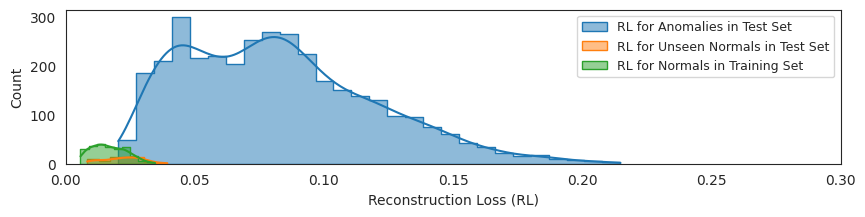

In [22]:
%matplotlib inline

plt.figure(figsize=(10, 2))

plt.xlim([0, 0.3])

sns.histplot(test_base_anormal_losses, element="step", label='RL for Anomalies in Test Set', kde=True)
sns.histplot(test_base_normal_losses, element="step", label='RL for Unseen Normals in Test Set', kde=True)
sns.histplot(train_base_losses, element="step", label='RL for Normals in Training Set', kde=True)

plt.legend(prop={'size': 9}, loc='best')
plt.xlabel('Reconstruction Loss (RL)')


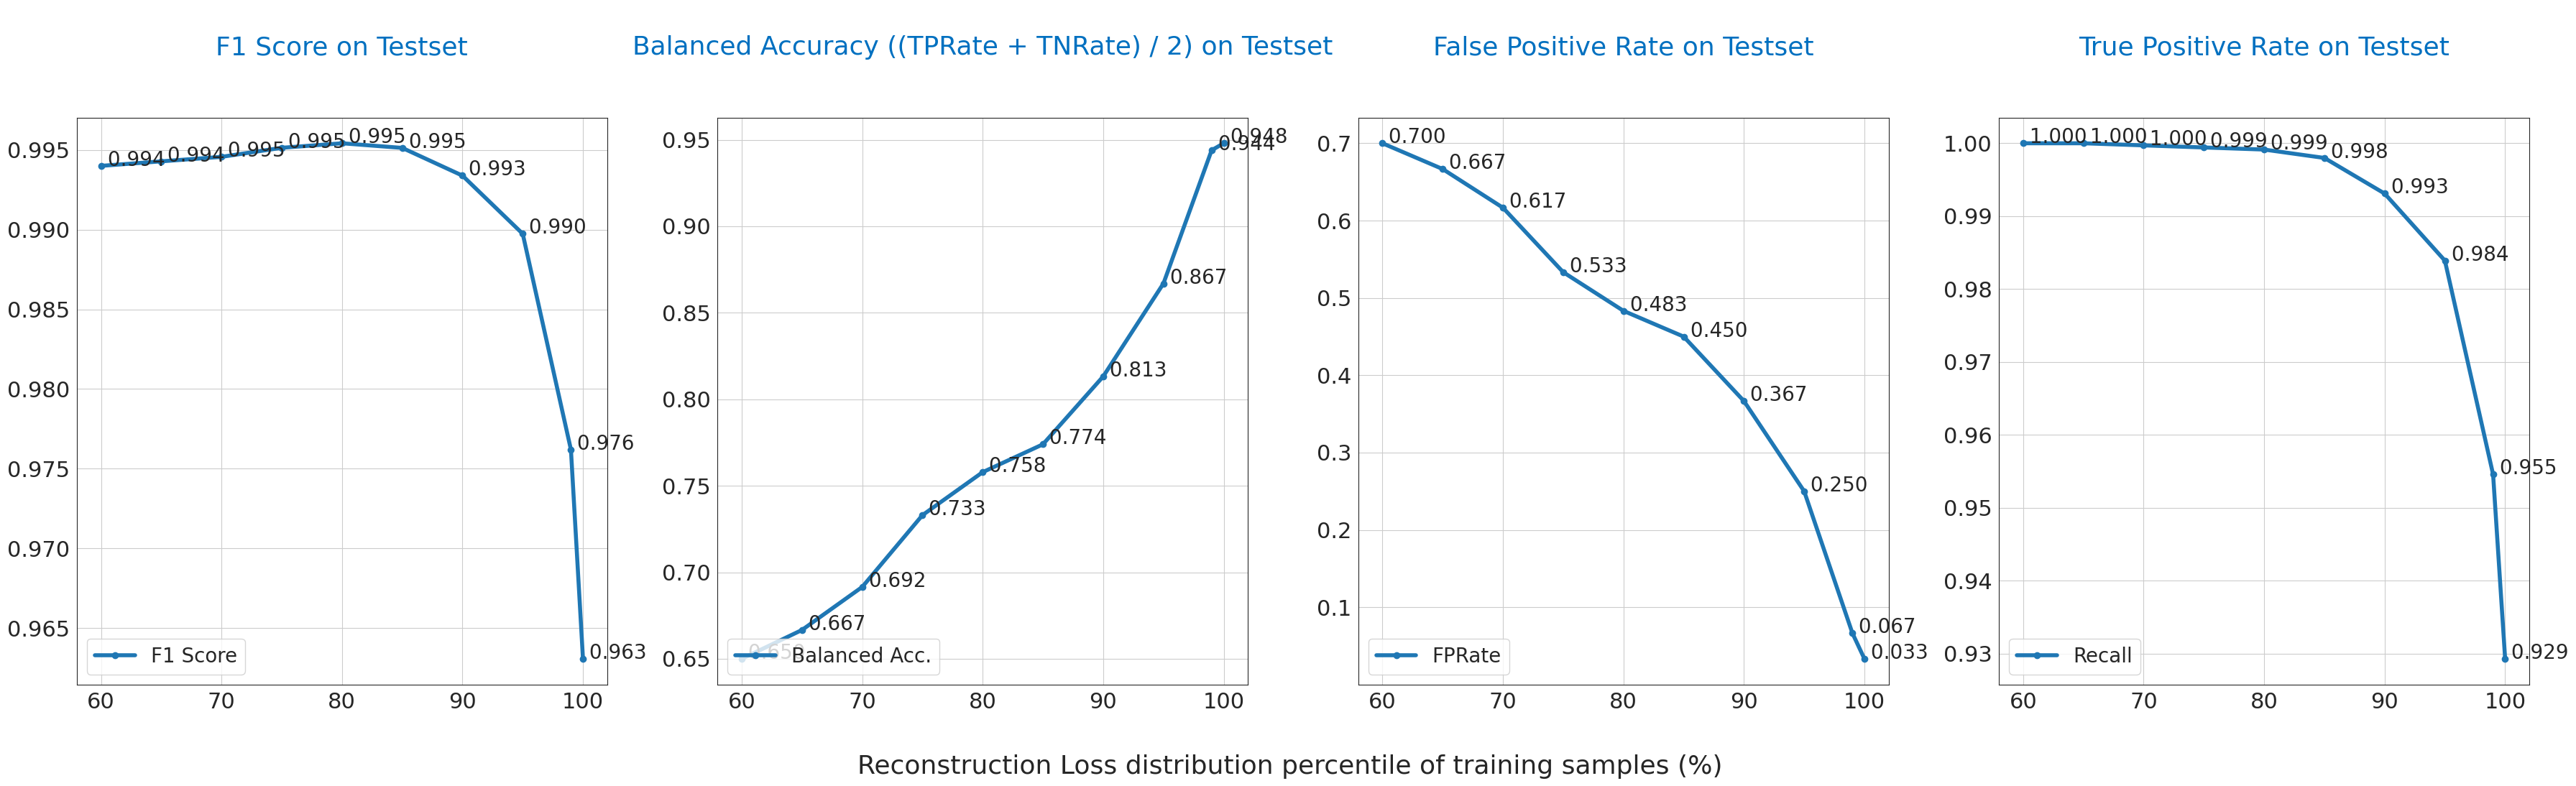

In [23]:
autoencoder_eval_utils.plot_all_metrics(F1s=F1s, BalancedAccuracies=BalancedAccuracies, FPRs=FPRs, Recalls=Recalls, percentiles=percentiles)